In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input,optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float'

In [15]:
# INIT
# PART 1
number_samples = [128, 256, 512, 1024, 2048, 4096, 8192] 
validation_size, noise_floor = 0.2, -110.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 299, 299, 3, 60  # su_size:30 for 1000, 10 for 100
cell_size, pixel_expansion = 1000 / max_x, 0.34
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope = 'log', 5  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_pus_num, max_sus_num = 20, 10
propagation_model = 'log' # 'splat', 'log', 'testbed'
noise, std = True, 1 # False for splat
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = False
if sensors:
    sensors_num = 49
    sensors_file_path = "../../java_workspace/research/commons/resources/sensors/square" \
    + str(max(max_x, max_y)) + "/placement/terrain-based/himanshu/" + str(sensors_num) + "/sensors.txt"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 10
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '_transfer/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (intensity_degradation + '_' + str(slope))) + (
    "/" + str(sensors_num) + "sensors" if sensors else "/pus_1_sus_3_channels") + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [3]:
image_dir

'ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/images'

In [58]:
# LOAD DATA
num_columns = (sensors_num if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 2
cols = [i for i in range(num_columns)]
dataset_name = "dynamic_pus_using_pus_1000000_min10_max20PUs_min1_max10SUs_square1000grid_log_noisy_std1.0_2021_10_03_18_25.txt"
max_dataset_name = "dynamic_pus_max_power_1000000_min10_max20PUs_min1_max10SUs_square1000grid_log_noisy_std1.0_2021_10_03_18_25.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
    set_file.write(max_dataset_name)

dataframe = pd.read_csv('data/' 
                        + dataset_name, delimiter=',', header=None, names=cols)
dataframe_max = pd.read_csv('data/' 
                            + max_dataset_name, delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)
dataframe_max[dataframe_max.shape[1] - 1] = dataframe_max[dataframe_max.shape[1] - 1].astype(float)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]], axis=1,
                        ignore_index=True)

idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)

data_reg = dataframe_tot.values
data_reg[data_reg < noise_floor] = noise_floor

if sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe, dataframe_tot, dataframe_max

In [21]:
data_reg[0,:]

array([ 1.7000e+01,  8.7300e+02,  4.0400e+02, -1.9092e+01,  4.0000e+02,
        3.8800e+02, -1.3100e-01,  2.9600e+02,  4.2700e+02, -6.1270e+00,
        3.8200e+02,  5.9600e+02, -2.4876e+01,  5.1400e+02,  3.0000e+02,
       -2.3366e+01,  4.0900e+02,  9.7100e+02, -2.1624e+01,  3.1700e+02,
        6.3100e+02, -6.3680e+00,  9.0500e+02,  2.5300e+02, -3.4060e+00,
        5.5200e+02,  9.0300e+02, -1.3216e+01,  9.4500e+02,  3.6400e+02,
       -1.5166e+01,  1.6700e+02,  2.3100e+02, -1.0489e+01,  5.4600e+02,
        4.8700e+02, -3.3360e+00,  7.9000e+02,  8.4500e+02, -2.0724e+01,
        5.2300e+02,  1.4600e+02, -1.1942e+01,  3.1300e+02,  2.8700e+02,
       -1.8686e+01,  5.6000e+02,  4.5400e+02, -2.0979e+01,  6.0600e+02,
        6.5400e+02, -1.0700e+00,  3.0000e+00,  5.8500e+02,  2.2900e+02,
        2.6713e+01,  4.5900e+02,  2.4800e+02,  1.6271e+01,  6.6100e+02,
        9.1000e+02,  5.4173e+01,  0.0000e+00,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [59]:
data_reg = data_reg[:500000][:]

In [6]:
data_reg_train = data_reg[:2048][:]

In [60]:
data_reg.shape

(500000, 94)

In [34]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5 * cell_size

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle', pu_param=None, 
                 su_shape='circle', su_param=None, intensity_degradation="log", max_pu_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((max_x, max_y, number_image_channels), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
                pu_p = data[pu_i * 3 + 3]
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y),
                                             shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[int(abs(pu_p))//10][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][0] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][0] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_param, ss_shape = pu_param, pu_shape
            for ss_i in range(sensors_num):
                ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x))), max(0, min(max_x-1, int(
                    sensors_location[ss_i].y))), max(noise_floor, data[ss_i])
                ss_channel = 0 
                if -62.5 <= ss_p < -50.0:
                    ss_channel = 1
                elif -75.0 <= ss_p < -62.6:
                    ss_channel = 2
                elif -87.5 <= ss_p < -75.0:
                    ss_channel = 3
                elif -100.0 <= ss_p < -87.5:
                    ss_channel = 4
#                 elif -70.0 <= ss_p < -65.0:
#                     ss_channel = 5
                elif ss_p < -100.0:
                    ss_channel = 5
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1] * pixel_expansion)))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2] * pixel_expansion)))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            su_param_p = get_pu_param(su_shape, intensity_degradation, su_p, noise_floor, slope)
            points = points_inside_shape(center=Point(su_x, su_y),
                                         param=su_param_p, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -2
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[point.p.x][point.p.y][su_channel] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1] * pixel_expansion)))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2] * pixel_expansion)))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y),
                                     param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[point.p.x][point.p.y][su_channel] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        pus_num = int(data[0])
        for pu_i in range(pus_num):
            pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
            pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
            pu_p = data[pu_i * 3 + 3]
            
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                            max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        else:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
#                                 max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        
        # creating SU image
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
            
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image       
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-int(r/cell_size), -max_x), 
                             min(int(r/cell_size), max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num, image_dir=image_dir):
    if False and style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
        suffix = 'npz'  # npy, npz
        image = np.load(image_dir + '/image' + str(image_num) + '.' + suffix)  
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image

In [186]:
data_img_train[0] = image

In [212]:
data_reg_train = np.repeat(data_reg[:2048], 4, axis=0)
image_state = ["", "rot", "lr", "ud"] * 2048
p = np.random.permutation(2048*4)
data_reg_train = data_reg_train[p]
new_image_state = []
for idx in range(2048*4):
    new_image_state.append(image_state[p[idx]])

In [11]:
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg_train[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0)
        if new_image_state[image_num] == "rot":
            image = np.rot90(image, 2)
        elif new_image_state[image_num] == "lr":
            image = np.fliplr(image)
        elif new_image_state[image_num] == "ud":
            image = np.flipud(image)
        np.savez_compressed(image_dir + '/image' + str(image_num), a=np.expand_dims(image,0 ))
        
        del image

In [223]:
jobs = []
proc_sizes = [data_reg_train.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg_train.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|██████████| 819/819 [14:16<00:00,  1.05s/it]


In [7]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0)
        if False and style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
    #         np.save(image_dir + '/image' + str(image_num), image)
            np.savez_compressed(image_dir + '/image' + str(image_num), a=np.expand_dims(image,0))
        del image

In [ ]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

  0%|                                                 | 0/50000 [00:00<?, ?it/s]

In [10]:
data_reg[1,:]

array([326.   , 947.   ,   4.415,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,   4.415])

In [42]:
imm = read_image(1)
new_imm = np.zeros((max_x, max_y), dtype=float_memory_used)
for x in range(max_x):
    for y in range(max_y):
        new_imm[x][y] = imm[0][x][y][1]

In [118]:
np.max(data_img_train)

0.0

In [62]:
imm = read_image(5)
immm = np.zeros((max_x, max_y, number_image_channels), dtype='float')
for x in range(max_x):
    for y in range(max_y):
        for ch in range(number_image_channels):
            immm[x][y][ch] = float(imm[0][x][y][ch])

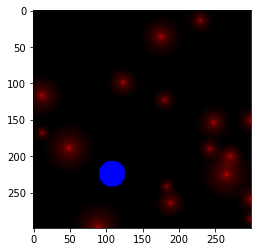

In [63]:
immm[immm>1] = 1.0
plt.imshow(immm)

In [53]:
data_reg[4,:]

array([ 2.0000e+01,  9.7300e+02,  9.0400e+02, -8.0650e+00,  9.0400e+02,
        7.0600e+02, -2.8769e+01,  9.7000e+02,  4.6900e+02, -3.6400e-01,
        3.3600e+02,  1.7900e+02, -1.3699e+01,  6.2700e+02,  7.3800e+02,
       -2.8409e+01,  7.4500e+02,  8.0000e+00, -2.8567e+01,  7.3100e+02,
        6.4200e+02, -2.8630e+00,  2.3600e+02,  6.4100e+02, -2.3589e+01,
        9.5700e+02,  8.3300e+02, -2.4575e+01,  8.0300e+02,  1.4100e+02,
       -1.6210e+01,  8.9400e+02,  7.4000e+01, -5.0770e+00,  5.9400e+02,
        3.6700e+02, -2.8099e+01,  2.0600e+02,  3.6900e+02, -2.2401e+01,
        3.9600e+02,  9.7800e+02, -1.3976e+01,  6.4900e+02,  1.9400e+02,
       -1.9651e+01,  9.7900e+02,  1.6100e+02, -5.2530e+00,  6.9900e+02,
        8.4700e+02, -2.6930e+00,  8.2900e+02,  9.7400e+02, -6.6510e+00,
        2.7000e+02,  5.9300e+02, -2.7123e+01,  6.0000e+02,  5.7200e+02,
       -2.7839e+01,  1.0000e+00,  7.6500e+02,  5.4100e+02,  3.3389e+01,
        0.0000e+00,         nan,         nan,         nan,      

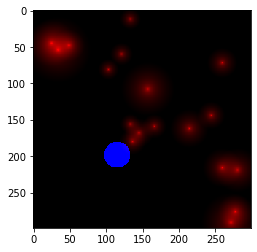

In [222]:

img_rot = ndimage.rotate(immm, -90, reshape=False)
img_rot = np.rot90(immm,2)
plt.imshow(img_rot)


<AxesSubplot:>

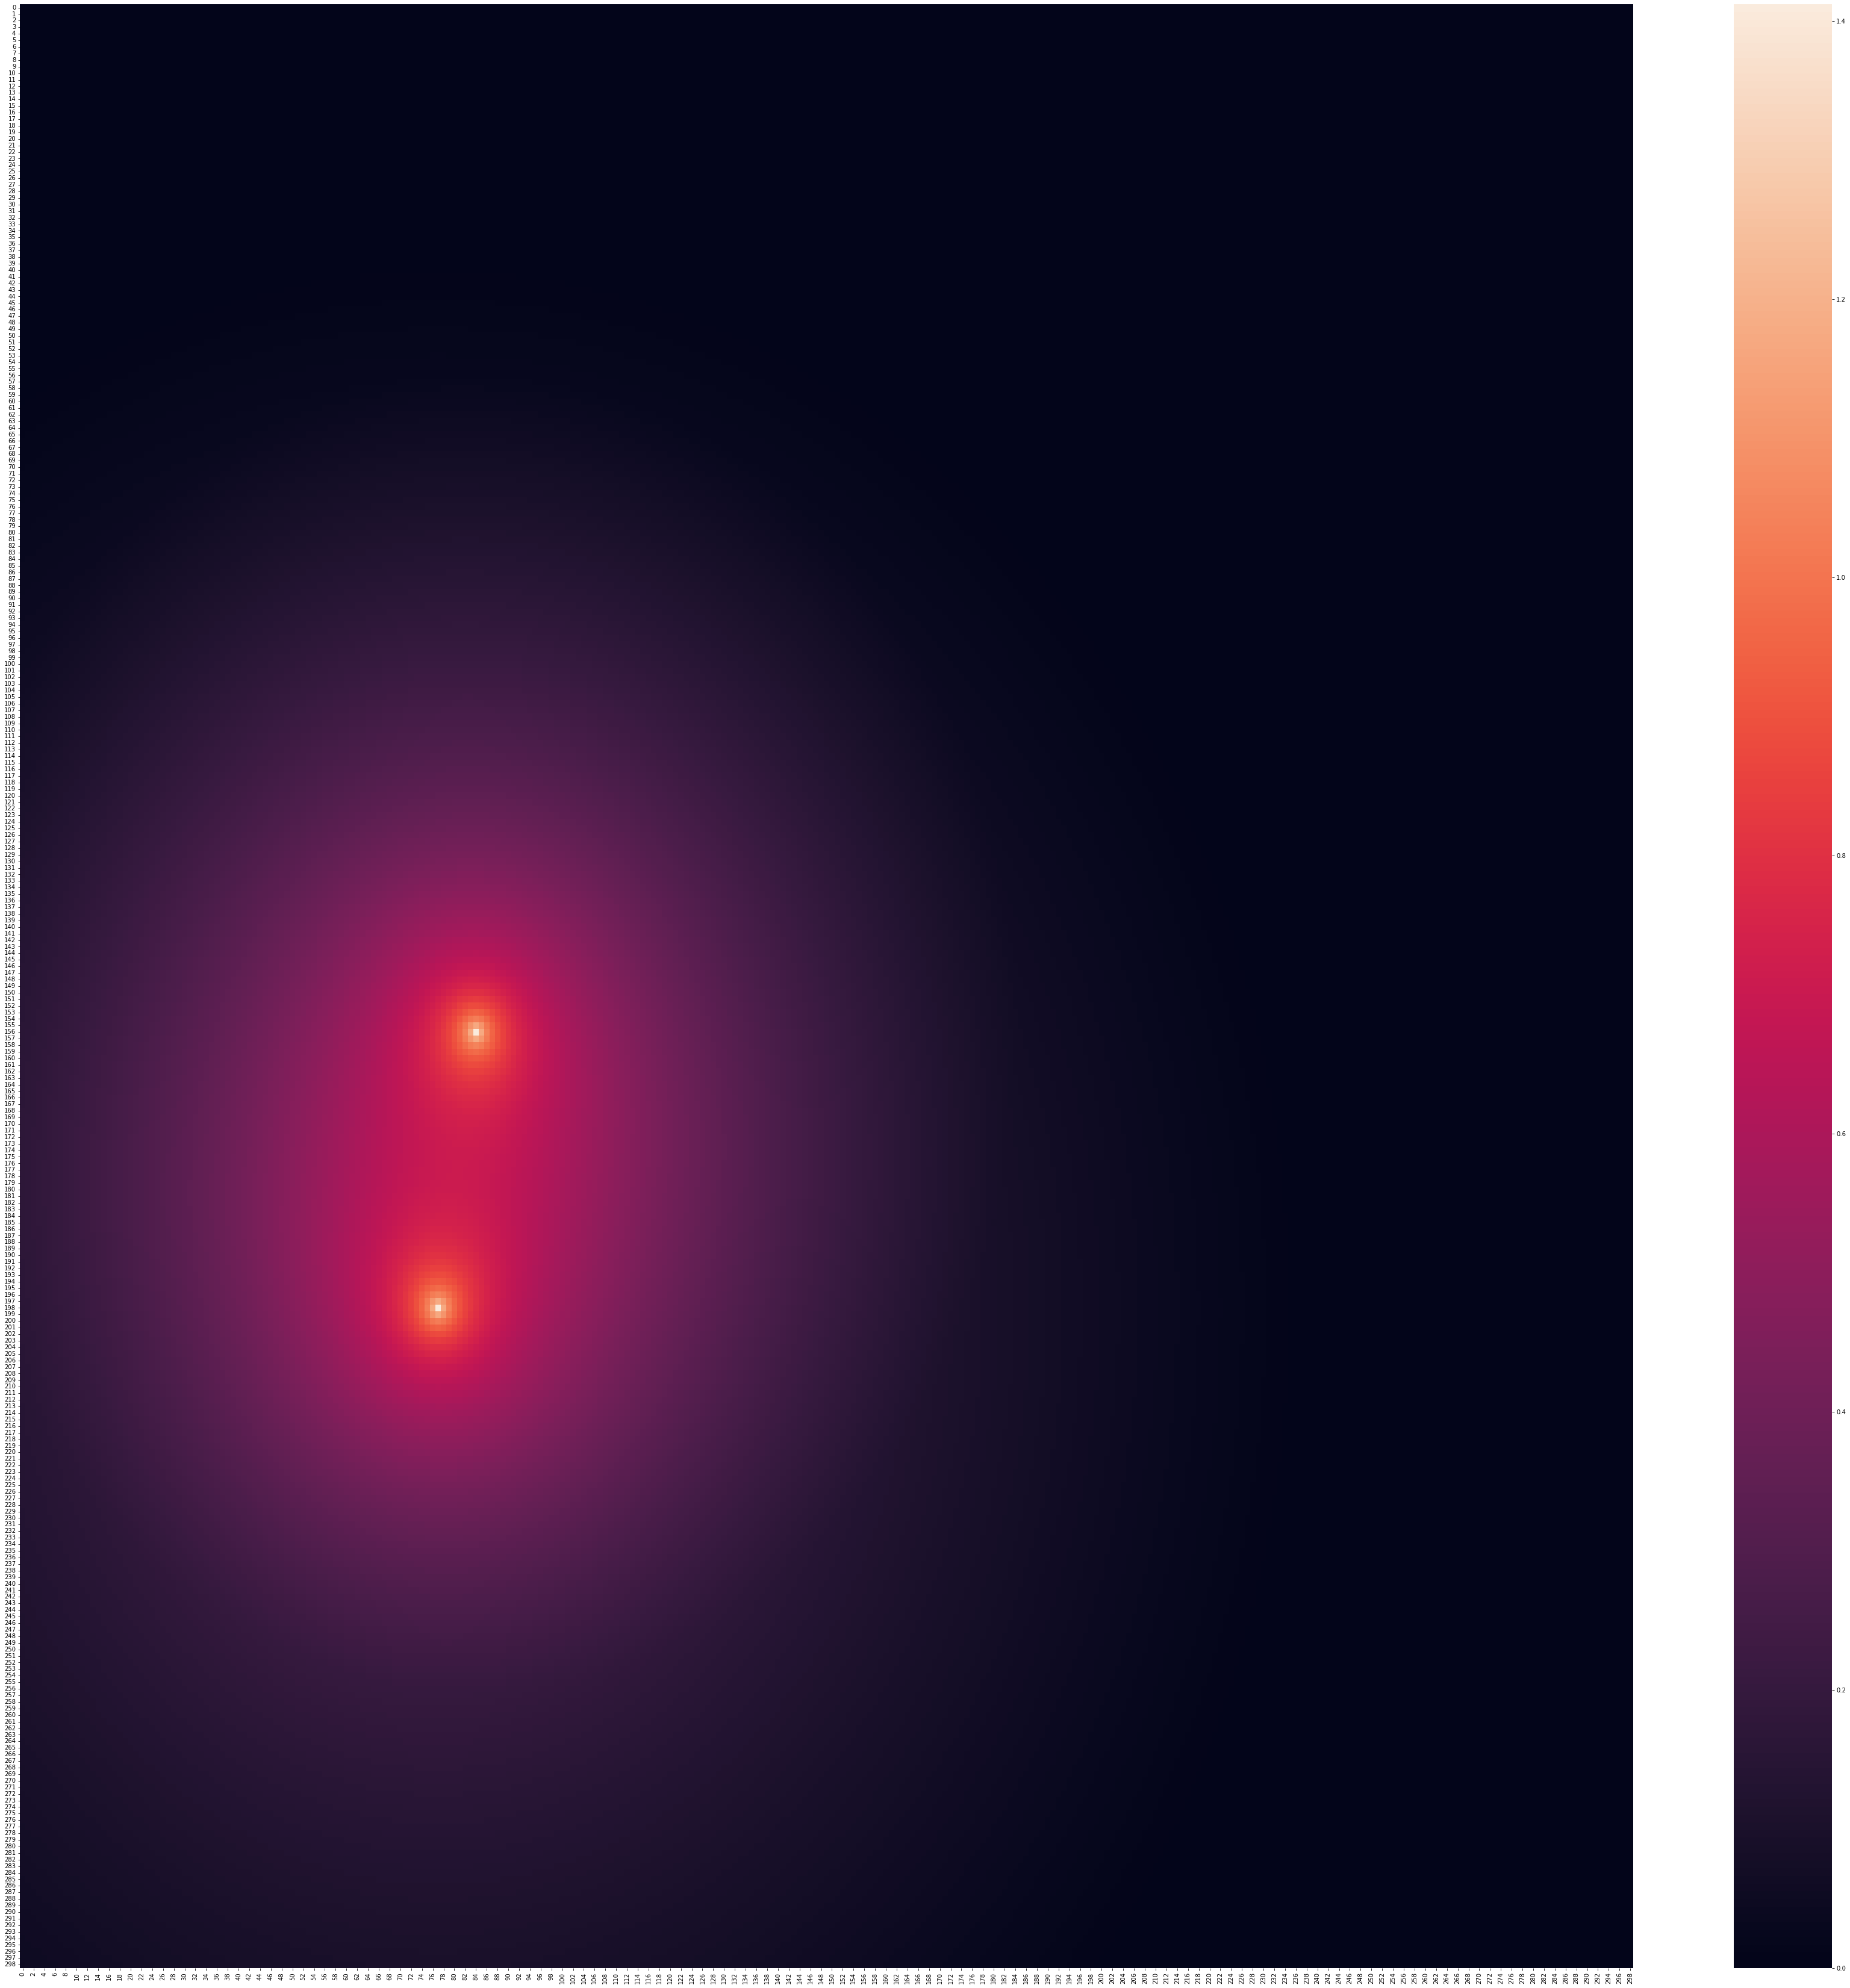

In [41]:

fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
sns.heatmap(new_imm, ax=ax)

In [8]:
# Xception model
base_model = applications.VGG16(include_top=False,
                                      weights="imagenet",
                                      input_shape=(max_x, max_y, number_image_channels))
base_model.trainable = False

2021-10-03 14:31:16.318240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 14:31:16.334301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 14:31:16.334603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 14:31:16.335199: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [10]:
def cnn_model(kernel_lam, bias_lam):
    inputs = Input(shape=(max_x, max_y, number_image_channels))
    convolution_filter, dense_filter = 'relu', 'linear'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.
    cnn = base_model(inputs, training=False)
    
#     cnn = layers.Dense(1024, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
#                              bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
#     cnn = layers.Dropout(0.5)(cnn)
    if True:
        # Convert features of shape `base_model.output_shape[1:]` to vectors
        cnn = layers.GlobalAveragePooling2D()(cnn)
        cnn = layers.Dense(1024, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
        cnn = layers.Dropout(0.5)(cnn)
        outputs = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init)(cnn)
        return Model(inputs, outputs)
    else:
        data_format="channels_last"
        filter_shape, pool_size = (1, 1), (2,2)
        cnn = layers.Conv2D(512, filter_shape, padding='same', 
                            activation=convolution_filter, data_format=data_format, 
                            kernel_regularizer=regularizers.l2(kernel_lam), 
                            bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(128, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(32, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(8, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(1, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.GlobalAveragePooling2D()(cnn)
        return Model(inputs, cnn)
    

class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, image_dir = image_dir, conserve=0):
#         print(dataset.shape[0])
#         print("generator initiated")
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
        self._image_dir = image_dir
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
#         print('generator yielded a batch %d' % idx)
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.max_x, self.max_y, self.number_image_channels), dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i, self._image_dir)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)


In [12]:
cnn1 = cnn_model(0, 0)

In [13]:
cnn1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
___________________________________________

In [11]:
tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2021-10-03 14:31:23.738798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 14:31:23.739071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 14:31:23.739249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 14:31:23.739442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 14:31:23.739612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

0033 MB memory:  -> device: 0, name: GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
number_samples = [2048*4]

In [14]:
# CNN: support batching
TEST, CONSERVE = False, False
mini_batch = 16 if max(max_x, max_y) == 1000 else 128
epochs = 35 if max(max_x, max_y) == 1000 else 300
MAX_QUEUE_SIZE, WORKERS = 100, 10
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0.1] 
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
    if CONSERVE:
        data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(), 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb_idx in range(len(lambda_vec))]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb_idx) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb_idx in range(len(lambda_vec))]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=0,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
#     if num_sample_idx == 3:    
#         models_min_mae = [8.27781, 8.23545, 8.20838, 7.74743]
#         models_min_mae += [min(cnns[lamb_idx].history.history[hyper_metric]) for lamb_idx in range(4,lamb_idx+1)]
#     else:
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator, checkpointers
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 8192 , New samples: 8192
Validation size: 1639 , starts: 8192 , ends: 9830

Epoch 00001: val_mae improved from inf to 7.07959, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/8192/best_model_lambda_0.h5

Epoch 00002: val_mae did not improve from 7.07959

Epoch 00003: val_mae improved from 7.07959 to 7.06534, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/8192/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 7.06534 to 7.05746, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/8192/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 7.05746 to 7.05308, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_ch

KeyboardInterrupt: 

In [17]:
cnns[0].history.history

{'loss': [95.79944610595703,
  81.62774658203125,
  80.92572021484375,
  80.991943359375,
  80.8129653930664,
  80.89397430419922,
  80.58321380615234,
  80.49980163574219],
 'mse': [81.45728302001953,
  79.95823669433594,
  79.79633331298828,
  80.08907318115234,
  80.01290893554688,
  80.1261215209961,
  79.88074493408203,
  79.81820678710938],
 'mae': [7.127552509307861,
  7.064125061035156,
  7.053989410400391,
  7.066105842590332,
  7.073051452636719,
  7.077786445617676,
  7.0602126121521,
  7.07376766204834],
 'fp_mae': [3.4902753829956055,
  3.4991323947906494,
  3.504276752471924,
  3.5100979804992676,
  3.494107723236084,
  3.50148868560791,
  3.4853546619415283,
  3.519373655319214]}

In [128]:
base_model.trainable = True

In [140]:
cnns[0].summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_25  (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
________________________________________

In [19]:
number_sample

8192

In [15]:
train_generator = DataBatchGenerator(dataset=data_reg[0:number_sample], batch_size=64,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

val_size = math.ceil(number_sample * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                   batch_size=32,
                                   start_idx=number_sample,
                                   number_image_channels=number_image_channels,
                                   max_x=max_x, max_y=max_y, 
                                   float_memory_used=float_memory_used,
                                  )

In [246]:
train_generator = DataBatchGenerator(dataset=data_reg_train[prev_sample:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

val_size = math.ceil(number_sample/4 * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample//4:number_sample//4+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample//4,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

In [35]:
MODEL_PATH

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_7_channels/models/8192/best_model_lambda_'

In [16]:
best_model = models.load_model(MODEL_PATH + str(0) + '.h5', 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
best_model.layers[1].trainable = True
best_model.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(1e-6), 
                        metrics=['mse', 'mae', fp_mae])

In [17]:
best_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 15,241,025
Non-trainable params: 0
_______________________________________________

In [18]:
best_model.fit(train_generator, epochs=50, verbose=0,
                   validation_data=val_generator, 
                   shuffle=True, callbacks=[ModelCheckpoint(filepath=MODEL_PATH + str(0)+ '_fine.h5',
                                           verbose=1, save_best_only=True, 
                                           monitor=hyper_metric,
                                           mode=mode)], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False)

2021-10-03 14:46:13.592526: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-03 14:46:13.592579: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-03 14:46:13.731745: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-03 14:46:13.731786: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc


Epoch 00001: val_mae improved from inf to 7.03051, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/8192/best_model_lambda_0_fine.h5

Epoch 00002: val_mae improved from 7.03051 to 6.96420, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/8192/best_model_lambda_0_fine.h5

Epoch 00003: val_mae improved from 6.96420 to 6.85334, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/8192/best_model_lambda_0_fine.h5

Epoch 00004: val_mae improved from 6.85334 to 6.64482, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/8192/best_model_lambda_0_fine.h5

Epoch 00005: val_mae improved from 6.64482 to 6.31809, saving model to ML/data/


Epoch 00048: val_mae did not improve from 3.88425

Epoch 00049: val_mae did not improve from 3.88425

Epoch 00050: val_mae improved from 3.88425 to 3.82351, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/8192/best_model_lambda_0_fine.h5


In [95]:
best_model.history.history

{'loss': [35.32899856567383,
  30.31448745727539,
  25.987943649291992,
  26.508663177490234,
  23.3116512298584,
  20.685850143432617,
  20.615081787109375,
  19.42974090576172,
  18.97920036315918,
  18.08241081237793,
  17.92743682861328,
  17.702444076538086,
  17.376569747924805,
  17.2484188079834,
  16.369810104370117,
  16.939908981323242,
  17.438913345336914,
  15.629339218139648,
  15.780244827270508,
  14.994789123535156,
  15.935834884643555,
  15.01628589630127,
  15.141878128051758,
  14.484707832336426,
  14.852530479431152,
  14.19215202331543,
  14.818056106567383,
  14.752556800842285,
  14.853983879089355,
  14.21522331237793],
 'mse': [27.532920837402344,
  22.533432006835938,
  18.222135543823242,
  18.7580623626709,
  15.574902534484863,
  12.963557243347168,
  12.906441688537598,
  11.734994888305664,
  11.298921585083008,
  10.416706085205078,
  10.276127815246582,
  10.065611839294434,
  9.754762649536133,
  9.641668319702148,
  8.77741813659668,
  9.362396240

In [255]:
best_model1 = models.load_model(MODEL_PATH + str(0) + '_fine.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample//4 + val_size:], 
                                    batch_size=32,
                                    start_idx=number_sample//4 + val_size, 
                                    number_image_channels=number_image_channels,
                                    max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
                                   image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

print("Test starts: ", number_sample//4 + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_model1.evaluate(test_generator, verbose=1, 
                                workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
test_mae_idx, test_fp_mae_idx = [best_model1.metrics_names.index(mtrc) 
                                for mtrc in ['mae','fp_mae']]
test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
average_diff_power.append(round(test_mae, 3))
fp_mean_power.append(round(test_fp_mae, 3))
print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
        fp_mean_power[-1])

Test starts:  2724 , ends:  10999
259/259 [==============================] - 66s 253ms/step - loss: 18.8749 - mse: 17.5575 - mae: 3.1179 - fp_mae: 1.6991
average_error:  3.118 , fp_average_error:  1.699


In [149]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     